In [ ]:
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import shutil
import pandas as pd

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.optimizers import Adam, Adamax, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

### **Data Preparation (train)**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Copy the train data to colab storage to read the image faster in next step

import shutil

# Define the source and destination paths
source_folder = '/content/drive/My Drive/DSBA data/DSBA_S3/Deep Learning/kvasir_12k/aug_images/'
destination_folder = '/content/kvasir_image'

# Copy the entire folder,  overwriting the destination if it exists
shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

'/content/kvasir_image'

In [ ]:
X = np.zeros((12000, 256, 256, 3), dtype=np.uint8)
images_path = '/content/kvasir_image'

for n,img in enumerate(os.listdir(images_path)):
    file_path = os.path.join(images_path, img)
    image = imread(file_path)
    image = resize(image, (256, 256), mode="constant", preserve_range=True)
    X[n] = image

### **Data Preparation (mask)**

In [ ]:
# Copy the train data to colab storage to read the image faster in next step

import shutil

# Define the source and destination paths
source_folder = '/content/drive/My Drive/DSBA data/DSBA_S3/Deep Learning/kvasir_12k/aug_masks/'
destination_folder = '/content/kvasir_mask'

# Copy the entire folder,  overwriting the destination if it exists
shutil.copytree(source_folder, destination_folder, dirs_exist_ok=True)

'/content/kvasir_mask'

In [ ]:
y = np.zeros((12000, 256, 256, 1), dtype=np.bool_)

mask_path = '/content/kvasir_mask'

for n,mask in enumerate(os.listdir(mask_path)):
    file_path = os.path.join(mask_path, mask)
    mask = imread(file_path)
    mask = rgb2gray(mask)
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    y[n] = mask

### **Build The Model**

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(f"X_train.shape: {X_train.shape}\ny_train.shape: {y_train.shape}")
print(f"X_test.shape: {X_test.shape}\ny_test.shape: {y_test.shape}")

X_train.shape: (9000, 256, 256, 3)
y_train.shape: (9000, 256, 256, 1)
X_test.shape: (3000, 256, 256, 3)
y_test.shape: (3000, 256, 256, 1)


In [ ]:
def conv_block(input, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(input)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(x)



    return x


#Encoder block: Conv block followed by maxpooling

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    return x, p


#Decoder block
#skip features gets input from encoder for concatenation

def decoder_block(input, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input)
    x = tf.keras.layers.concatenate([x, skip_features])
    x = conv_block(x, num_filters)
    return x


#Build Unet using the blocks
def build_unet(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 64)

    b1 = conv_block(p2, 512) #Bridge

    d1 = decoder_block(b1, s2, 64)
    d2 = decoder_block(d1, s1, 64)

    outputs = Conv2D(n_classes, 1, padding="same", activation='sigmoid')(d2)

    model = Model(inputs, outputs, name="U-Net-1")
    return model


# function to create iou coefficient
def iou_coef(y_true, y_pred, smooth=100):
    y_true = tf.cast(y_true, dtype=tf.float32) # Cast y_true to float32
    y_pred = tf.cast(y_pred, dtype=tf.float32) # Cast y_pred to float32
    intersection = K.sum(y_true * y_pred)
    sum = K.sum(y_true + y_pred)
    iou = (intersection + smooth) / (sum - intersection + smooth)
    return iou

In [ ]:
input_shape = (256, 256, 3)
model_baseline = build_unet(input_shape, n_classes=1)
model_baseline.compile(optimizer=Adam(learning_rate = 1e-3), loss='binary_crossentropy', metrics=['accuracy', iou_coef])
model_baseline.summary()

Model: "U-Net-1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 256, 256, 64)   │          1,792 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_72[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_73[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_74[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_75[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_76[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 256, 256, 64)   │         36,928 │ conv2d_77[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 128, 128, 64)   │              0 │ conv2d_78[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_79[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_81 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_80[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_82 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_81[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_83 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_82[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_84 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_83[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_85 (Conv2D)        │ (None, 128, 128, 64)   │         36,928 │ conv2d_84[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 64, 64, 64)     │              0 │ conv2d_85[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_86 (Conv2D)        │ (None, 64, 64, 512)    │        295,424 │ max_pooling2d_5[0][0]  │
├──────────────────────

 Total params: 15,674,497 (59.79 MB)

 Trainable params: 15,674,497 (59.79 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history1 = model_baseline.fit(X_train, y_train,
                    batch_size = 64,
                    verbose=1,
                    epochs=20,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 123s 784ms/step - accuracy: 0.7759 - iou_coef: 0.0901 - loss: 147.5286 - val_accuracy: 0.8324 - val_iou_coef: 0.1205 - val_loss: 0.4385
Epoch 2/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 104s 740ms/step - accuracy: 0.8305 - iou_coef: 0.1248 - loss: 0.4374 - val_accuracy: 0.8324 - val_iou_coef: 0.1270 - val_loss: 0.4059
Epoch 3/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 104s 740ms/step - accuracy: 0.8305 - iou_coef: 0.1421 - loss: 0.4074 - val_accuracy: 0.8324 - val_iou_coef: 0.0876 - val_loss: 0.4631
Epoch 4/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 104s 740ms/step - accuracy: 0.8316 - iou_coef: 0.1664 - loss: 0.3896 - val_accuracy: 0.8403 - val_iou_coef: 0.2039 - val_loss: 0.3566
Epoch 5/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 104s 740ms/step - accuracy: 0.8361 - iou_coef: 0.1895 - loss: 0.3619 - val_accuracy: 0.8408 - val_iou_coef: 0.1842 - val_loss: 0.3481
Epoch 6/20
141/141 ━━━━━━━━━━━━━━━━━━━━ 104s 740ms/step - accuracy: 0.8396 - iou_coef: 0.1996 - loss: 0.3538 - val_accuracy: 0.8

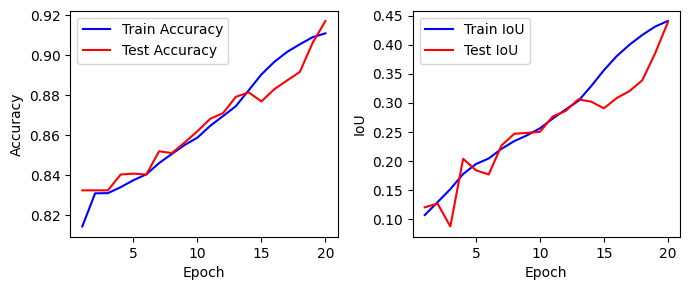

In [ ]:
import matplotlib.pyplot as plt

acc2 = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
iou2 = history1.history['iou_coef']
val_iou = history1.history['val_iou_coef']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, iou2,'b',label='Train IoU')
axes[1].plot(epochs, val_iou,'r',label='Test IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/kvasir1_epoch20.hdf5')

### **Hyperparameter Tuning**

In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.2 MB/s eta 0:00:00


In [ ]:
# prompt: hyperparameter tuning using kerastuner


import keras_tuner as kt

def build_model(hp):
    input_shape = (256, 256, 3)
    inputs = Input(input_shape)

    # Hyperparameters for the number of filters in each layer
    filters_1 = hp.Int('filters_1', min_value=32, max_value=64, step=16)
    filters_2 = hp.Int('filters_2', min_value=32, max_value=64, step=16)
    filters_bridge = hp.Int('filters_bridge', min_value=256, max_value=1024, step=256)

    s1, p1 = encoder_block(inputs, filters_1)
    s2, p2 = encoder_block(p1, filters_2)

    b1 = conv_block(p2, filters_bridge) #Bridge

    d1 = decoder_block(b1, s2, filters_2)
    d2 = decoder_block(d1, s1, filters_1)

    outputs = Conv2D(1, 1, padding="same", activation='sigmoid')(d2)

    model = Model(inputs, outputs, name="U-Net-Tuned")

    # Hyperparameters for learning rate and optimizer
    learning_rate = hp.Choice('learning_rate', values=[5e-3])
    optimizer = hp.Choice('optimizer', values=['adamax', 'rmsprop'])

    if optimizer == 'adamax':
        optimizer = Adamax(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', iou_coef])
    return model


tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective("val_iou_coef", direction="max"),
    max_trials=5,  # Specify the maximum number of trials
    directory='my_dir',
    project_name='kvasir_tuning',
    overwrite=True
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), shuffle=False)


Trial 5 Complete [00h 29m 32s]
val_iou_coef: 0.14146742224693298

Best val_iou_coef So Far: 0.4505597651004791
Total elapsed time: 01h 38m 29s


In [ ]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
best_model = tuner.hypermodel.build(best_hps)

# Train the best model
history = best_model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 120s 387ms/step - accuracy: 0.7923 - iou_coef: 0.1103 - loss: 7.3822 - val_accuracy: 0.8334 - val_iou_coef: 0.1711 - val_loss: 0.3876
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 103s 366ms/step - accuracy: 0.8309 - iou_coef: 0.1753 - loss: 0.3913 - val_accuracy: 0.8366 - val_iou_coef: 0.1501 - val_loss: 0.4053
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 103s 366ms/step - accuracy: 0.8366 - iou_coef: 0.1952 - loss: 0.3702 - val_accuracy: 0.8421 - val_iou_coef: 0.1975 - val_loss: 0.3626
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 103s 366ms/step - accuracy: 0.8465 - iou_coef: 0.2208 - loss: 0.3444 - val_accuracy: 0.8635 - val_iou_coef: 0.2532 - val_loss: 0.3140
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 103s 366ms/step - accuracy: 0.8581 - iou_coef: 0.2544 - loss: 0.3231 - val_accuracy: 0.8401 - val_iou_coef: 0.2770 - val_loss: 0.3600
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 103s 367ms/step - accuracy: 0.8616 - iou_coef: 0.2614 - loss: 0.3148 - val_accuracy: 0.870

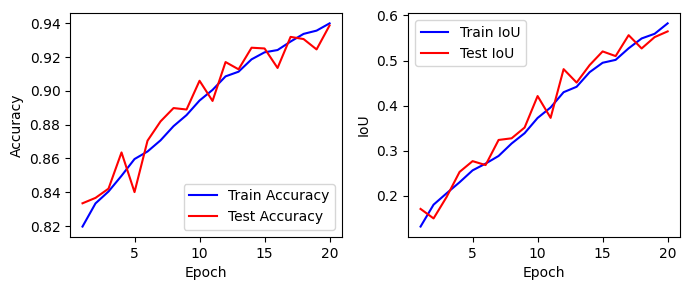

In [ ]:
import matplotlib.pyplot as plt

acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
iou2 = history.history['iou_coef']
val_iou = history.history['val_iou_coef']

epochs = range(1,len(acc2)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2,'b',label='Train Accuracy')
axes[0].plot(epochs, val_acc,'r',label='Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, iou2,'b',label='Train IoU')
axes[1].plot(epochs, val_iou,'r',label='Test IoU')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('IoU')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [ ]:
best_model.save('/content/drive/MyDrive/Colab Notebooks/saved_models/kvasir1_epoch20_tuned.hdf5')